In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
import csv

#problem: contains many nans. before using pandas we need to know how to handle it.
def read_df(path=""):
    return pd.read_table(path+"case1Data.txt", delimiter=",")


def read_var_names(path=""):
    with open(path+'var_names.txt', newline='') as f:
        reader = csv.reader(f)
        var_names = list(reader)
    var_names = var_names[0]
    names = [x.replace(" ","").replace("_","") for x in var_names]
    return names


def update_plt_cfg():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 16
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def split_data(df):
    dfNumeric = df.iloc[:, :96]
    dfCategorical = df.iloc[:, 96:]
    return dfNumeric, dfCategorical

def convertNumeric(df):
    #fix it so NaNs are not strings but rather np.NaN
    for col in df.columns:
        df[col]=pd.to_numeric(df[col], errors="coerce")
    return df

def missingValueInformation(df,plot=False):
    #checks the number of rows / cols with minimally one missing value
    #input:   numeric pandas df
    #returns: two pandas series objects for illustration.
    #           - the distribution of nans across variables
    #           - the distribution of nans across observations

    #obtain distribution as pandas series
    variable_nan_distribution = np.sum(np.isnan(df),axis=0)
    obs_nan_distribution = np.sum(np.isnan(df),axis=1)

    #check for minimally one value
    obs_min_one_missing = sum(df.apply(lambda x: sum(x.isnull().values), axis = 1)>0)
    var_min_one_missing = sum(df.apply(lambda x: sum(x.isnull().values), axis = 0)>0)
    print(f"At least one missing value occuring in {var_min_one_missing}/{df.shape[1]} variables")
    print(f"At least one missing value occuring in {obs_min_one_missing}/{df.shape[0]} observations")

    #mean number of missing values 
    print(f"Mean count missing per variable {np.mean(variable_nan_distribution)}")
    print(f"Mean count missing per observation {np.mean(obs_nan_distribution)}")
    

    #fix pandas series so it is easily plottable using seaborn
    variable_nan_distribution = variable_nan_distribution.rename_axis("variable").reset_index(name="count")
    obs_nan_distribution =  obs_nan_distribution.rename_axis("observation").reset_index(name="count")
    if(plot==True):
        missingValuePlots(variable_nan_distribution,obs_nan_distribution)

    return variable_nan_distribution, obs_nan_distribution


def missingValuePlots(var_df,obs_df):
    fig, ax = plt.subplots(2,1,figsize=(18,12))
    #fig.suptitle("number of missing values per variable")
    #plt.xticks(rotation=90)
    b1 = sns.barplot(data=var_df,x="variable",y="count",ax=ax[0])
    b2 = sns.barplot(data=obs_df,x="observation",y="count",ax=ax[1])
    for ax_ in ax:
        for tick in ax_.get_xticklabels():
            tick.set_rotation(90)
    ax[0].set_title("Missing values across variables",fontweight="bold",fontsize=16)
    ax[1].set_title("Missing values across observations",fontweight="bold",fontsize=16)
    
    fig.tight_layout()
    plt.show()

    fig.savefig('plots/missing_values.png')
    return None

def standardize_col(column):
    return (column - column.mean()) / column.std()

def standardize_df(df):
    scaler = StandardScaler() 
    df2 = scaler.fit_transform(df) 
    return df2

def printHighCorrelations(corrdf, k = 3):
    #prints and returns the three highest correlations per variable
    var_names = read_var_names()
    corrdf -= np.identity(corrdf.shape[0])*100.0 #kill diagonals just to be sure
    corrdf *= np.tri(*corrdf.shape) #kill upper triangular to 0.0  
    #get top three correlations
    completeMax = np.argmax(corrdf,axis=0)

    #print(corrdf)
    ind = np.argsort(corrdf,axis=0) #sort array along rows in ascending order, keep indices of argmax
    #print(ind)
    ind = ind[-k:,:] 
    #print(ind)
    for var in range(ind.shape[1]):
        print(f"{var_names[var]}")
        for maxInd in ind[:,var]:
            print(f"\tcorr with {var_names[maxInd]}: {corrdf[maxInd,var]}")
    return
    


def covariance_plot(df,title=None,covAnalysis=False):
    df_standardized = df.apply(standardize_col) 
    covs = df_standardized.cov().to_numpy()
    corrs = df_standardized.corr(numeric_only=True).to_numpy()
    fig, ax = plt.subplots(2,1,figsize=(10,10))
    covIm = ax[0].imshow(covs,cmap="viridis")
    #plt.colorbar(covIm,ax=ax[0])
    ax[0].set_title("Cov: " + title)
    plt.colorbar(covIm,fraction=0.046, pad=0.04)
    
    corrIm = ax[1].imshow(corrs,cmap="viridis")
    #cax = fig.add_axes([ax[1].get_position().x1-0.25,ax[1].get_position().y0,0.02,ax[0].get_position().y1-ax[1].get_position().y0])
    #fig.colorbar(covIm, cax=cax)
    plt.colorbar(corrIm,fraction=0.046, pad=0.04)
    ax[1].set_title("Corr: " + title)



    if(covAnalysis):
        printHighCorrelations(corrs)
    return 


#def standardize_data(df):


At least one missing value occuring in 95/96 variables
At least one missing value occuring in 100/100 observations
Mean count missing per variable 14.385416666666666
Mean count missing per observation 13.81


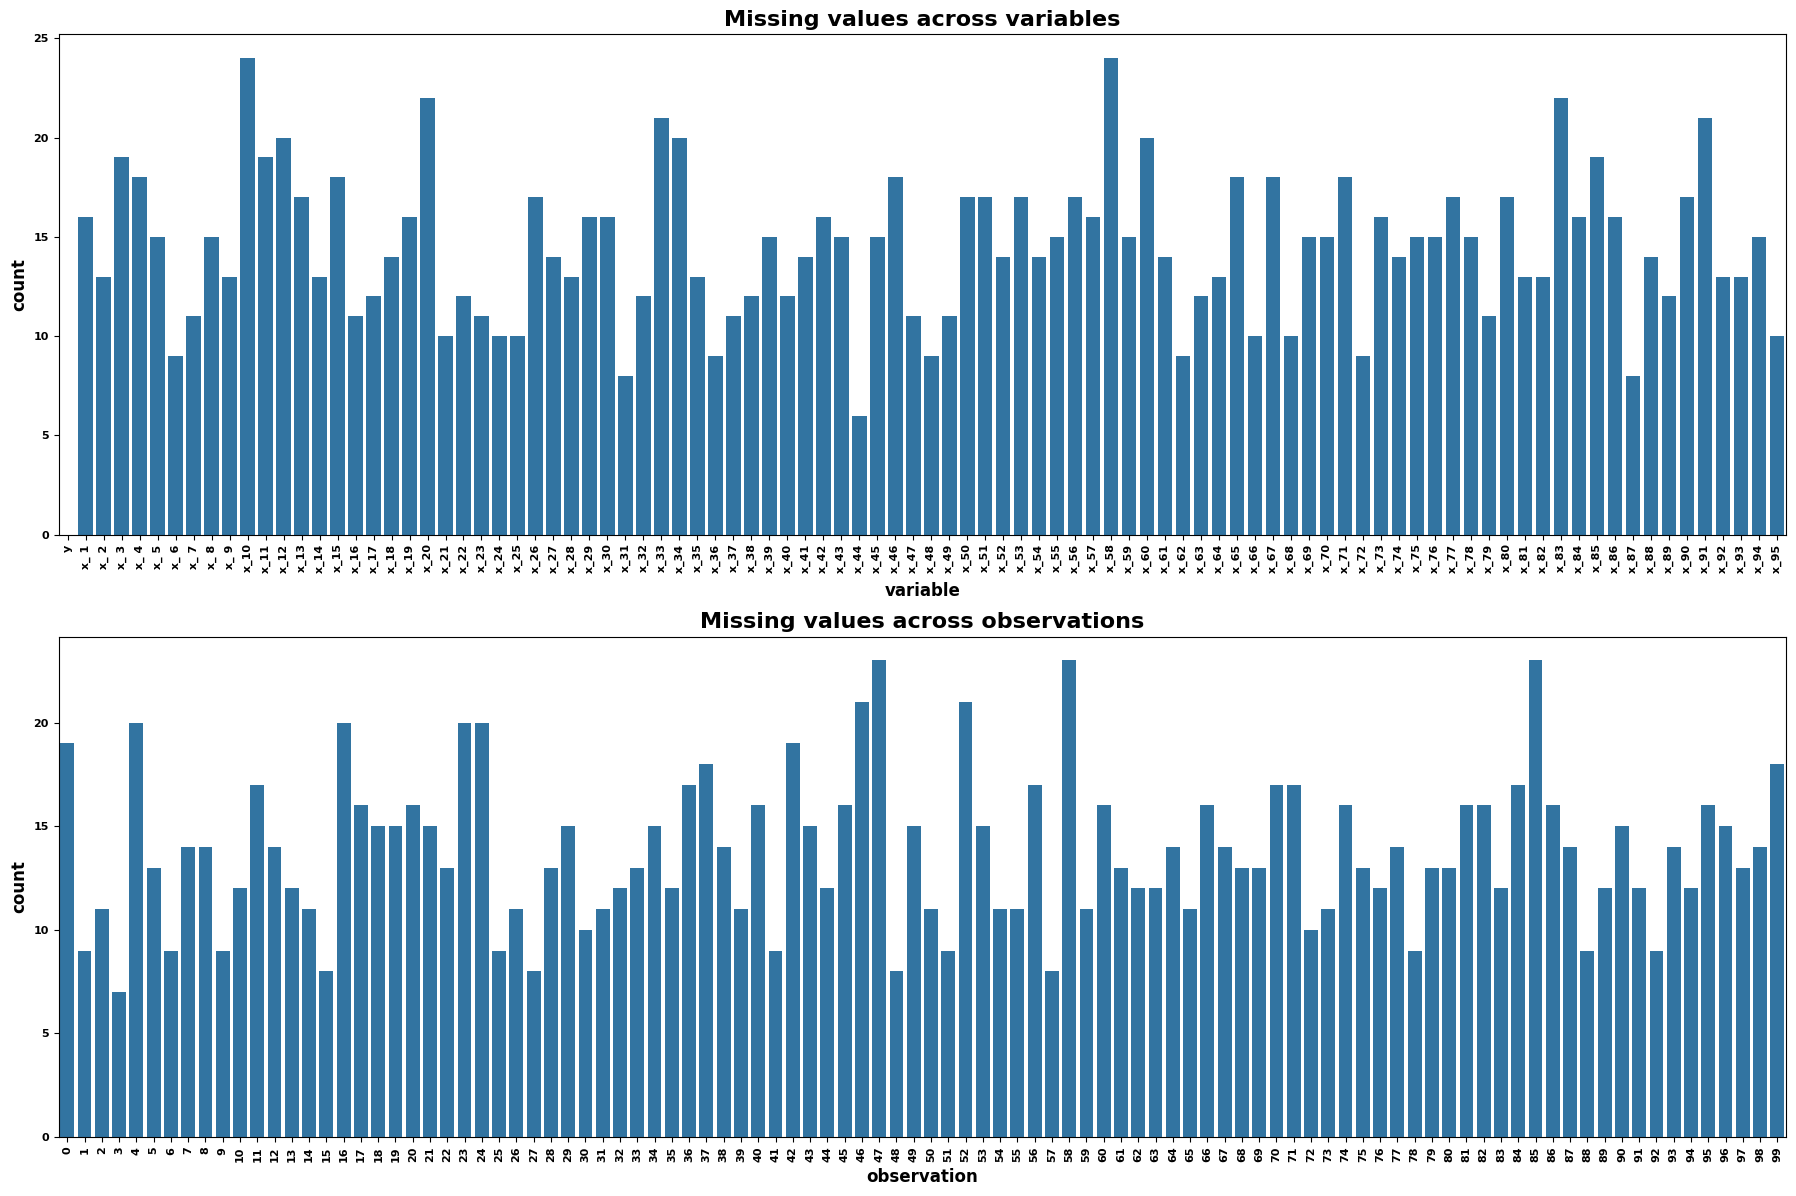

In [135]:
update_plt_cfg()
train_data = read_df()
numeric_df, categorical_df = split_data(train_data)
numeric_df = convertNumeric(numeric_df)
var_missing_dist,obs_nan_dist = missingValueInformation(numeric_df,plot=True)

y
	corr with x54: 0.6153796658722872
	corr with x3: 0.6233595943662354
	corr with x62: 0.6876715009638525
x1
	corr with x70: 0.5846372352505764
	corr with x60: 0.5901853817612015
	corr with x16: 0.6086568661736248
x2
	corr with x84: 0.5550107585094094
	corr with x33: 0.5643219621942995
	corr with x59: 0.6759618187649605
x3
	corr with x46: 0.6180585329346066
	corr with x61: 0.6502427893719482
	corr with x54: 0.6622619118720513
x4
	corr with x82: 0.5610249433699918
	corr with x71: 0.5767069036949087
	corr with x92: 0.6022421031989788
x5
	corr with x39: 0.631622581443235
	corr with x46: 0.6375958096364382
	corr with x64: 0.6407673284038077
x6
	corr with x46: 0.581271898797597
	corr with x54: 0.5841345261342036
	corr with x28: 0.6522980160647383
x7
	corr with x18: 0.5599847073474747
	corr with x89: 0.5739943944594884
	corr with x9: 0.5839098598084752
x8
	corr with x46: 0.6264287574164864
	corr with x70: 0.6355188587519772
	corr with x68: 0.6471353292483141
x9
	corr with x10: 0.644803885026

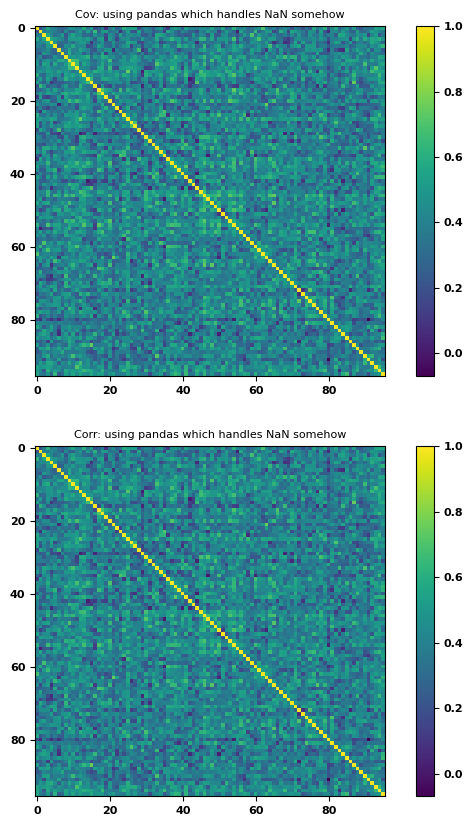

In [232]:
#norm_df = numeric_df.copy(deep=True)
#print(standardize_df(norm_df))
covariance_plot(numeric_df,title="using pandas which handles NaN somehow",covAnalysis=True)

In [228]:
printHighCorrelations(np.arange(0,16,dtype="float").reshape(4,4),k=2)

[[-100.    0.    0.    0.]
 [   4.  -95.    0.    0.]
 [   8.    9.  -90.    0.]
 [  12.   13.   14.  -85.]]
[[0 1 2 3]
 [1 0 0 0]
 [2 2 1 1]
 [3 3 3 2]]
[[2 2 1 1]
 [3 3 3 2]]
y
	corr with x2: 8.0
	corr with x3: 12.0
x1
	corr with x2: 9.0
	corr with x3: 13.0
x2
	corr with x1: 0.0
	corr with x3: 14.0
x3
	corr with x1: 0.0
	corr with x2: 0.0


In [237]:
#test = np.arange(0,16,dtype="float").reshape(4,4)
#np.argpartition(test,-3)[-3:]

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])